In [285]:
## Hilfsfunktion

import numpy as np
import matplotlib.pyplot as plt

# z-scaler
def z_scale(data):
    data = np.array(data)
    return (data - np.mean(data)) / np.std(data)

# rw function (according to chapter 2)
def rw(ys, w, pflag=False):
    l = len(ys)
    peaks_bottoms = np.zeros((l, 2))    
    for i in range(w, l - w):
        if ys[i] > max(ys[i - w:i]) and ys[i] > max(ys[i + 1:i + w]):
            peaks_bottoms[i, 0] = 1
        if ys[i] < min(ys[i - w:i]) and ys[i] < min(ys[i + 1:i + w]):
            peaks_bottoms[i, 1] = 1


    p_indx = np.where(peaks_bottoms[:, 0] == 1)[0] 
    b_indx = np.where(peaks_bottoms[:, 1] == 1)[0]

    peaks = np.array([ [ys[i],i] for i in p_indx ])
    bottoms = np.array([ [ys[i],i] for i in b_indx ])

    if pflag:
        plt.figure(figsize=(8, 4))
        plt.plot(ys, label='Series', color='lightgray')
        if len(peaks): plt.plot(peaks[:, 1], peaks[:, 0], 'ro', label='Peaks')
        if len(bottoms): plt.plot(bottoms[:, 1], bottoms[:, 0], 'r*', label='Bottoms')
        plt.title('Peak and Bottom Detection')
        plt.legend()

    return peaks, bottoms

In [127]:
## Zufällige Daten generieren

import numpy as np

NUM_ASSETS = 10
RANDOM_SEED = 42
START = '2020-01-01'
END = '2024-08-31'

np.random.seed(RANDOM_SEED)
dates = np.arange(START, END, dtype='datetime64[D]')
names = []
prices = []
derivatives = []
scaledDerivates = []
for i in range(NUM_ASSETS):
    names.append(f"Asset {i+1}")
    prices.append(np.cumsum(np.random.randn(len(dates)) * 2) + 100)
    derivatives.append(np.diff(prices[i],axis=0))
    scaledDerivates.append(z_scale(derivatives[i]))


In [248]:
## Daten von Yahoo Finance abrufen

import yfinance

START = '2020-01-01'
END = '2024-08-31'
names = ['MSFT','AAPL','GOOGL']

prices = []
derivatives = []
scaledDerivates = []
dates = np.arange(START, END, dtype='datetime64[D]')
for i in range(len(names)):
    assetTicker = yfinance.Ticker(names[i])
    assetHistory = assetTicker.history(interval='1d',start=START,end=END)

    lastValue = assetHistory['Open'].iloc[0]
    dataPointer = 0
    index = assetHistory.index
    prices.append([])
    for date in dates:
        if dataPointer < len(index) and index[dataPointer].strftime("%Y-%m-%d") == str(date):
            prices[i].append(assetHistory['Close'].iloc[dataPointer])
            lastValue=assetHistory['Close'].iloc[dataPointer]
            dataPointer += 1
        else:
            prices[i].append(lastValue)
    derivatives.append(np.diff(prices[i],axis=0))
    scaledDerivates.append(z_scale(derivatives[i]))


Peaks and Bottoms for MSFT:


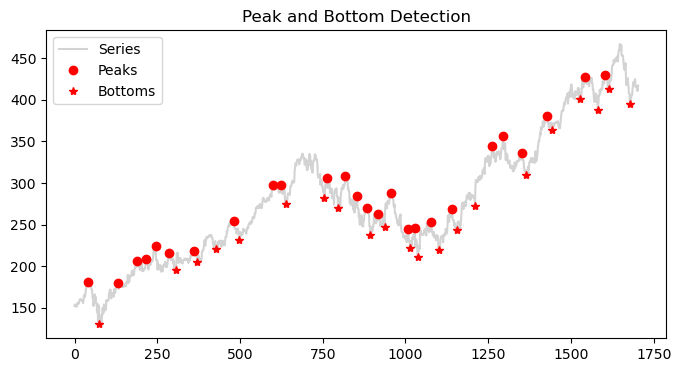

Peaks and Bottoms for AAPL:


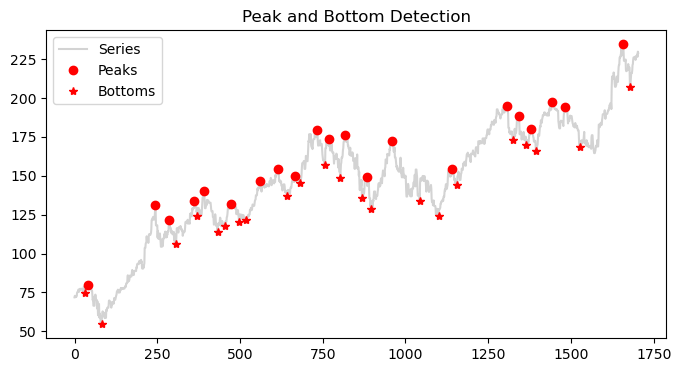

Peaks and Bottoms for GOOGL:


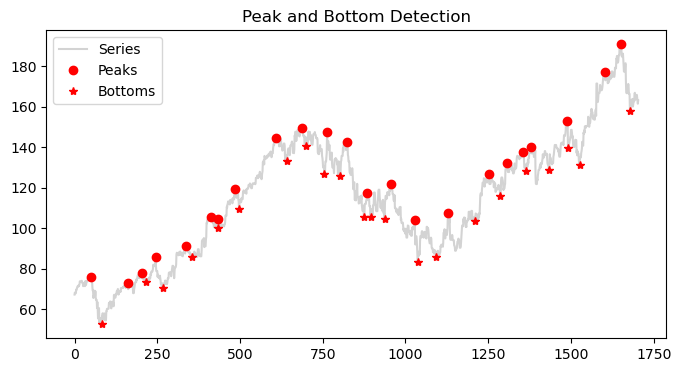

In [250]:
# Peaks und Bottoms ermitteln/darstellen

WINDOW_LENGTH=20

for i in range(len(names)):
    print(f"Peaks and Bottoms for {names[i]}:")
    rw(prices[i],WINDOW_LENGTH,True)

In [251]:
## Smoothing der der Daten

import scipy
import scipy.signal

WINDOW_LENGTH = 15
POLYNOM_ORDER = 2

smoothedPrices = []
smoothedDerivatives = []
smoothedScaledDerivatives = []

for i in range(len(names)):
    smoothedPrices.append(scipy.signal.savgol_filter(prices[i], WINDOW_LENGTH, POLYNOM_ORDER))
    smoothedDerivatives.append(scipy.signal.savgol_filter(derivatives[i], WINDOW_LENGTH, POLYNOM_ORDER))
    smoothedScaledDerivatives.append(scipy.signal.savgol_filter(scaledDerivates[i], WINDOW_LENGTH, POLYNOM_ORDER))


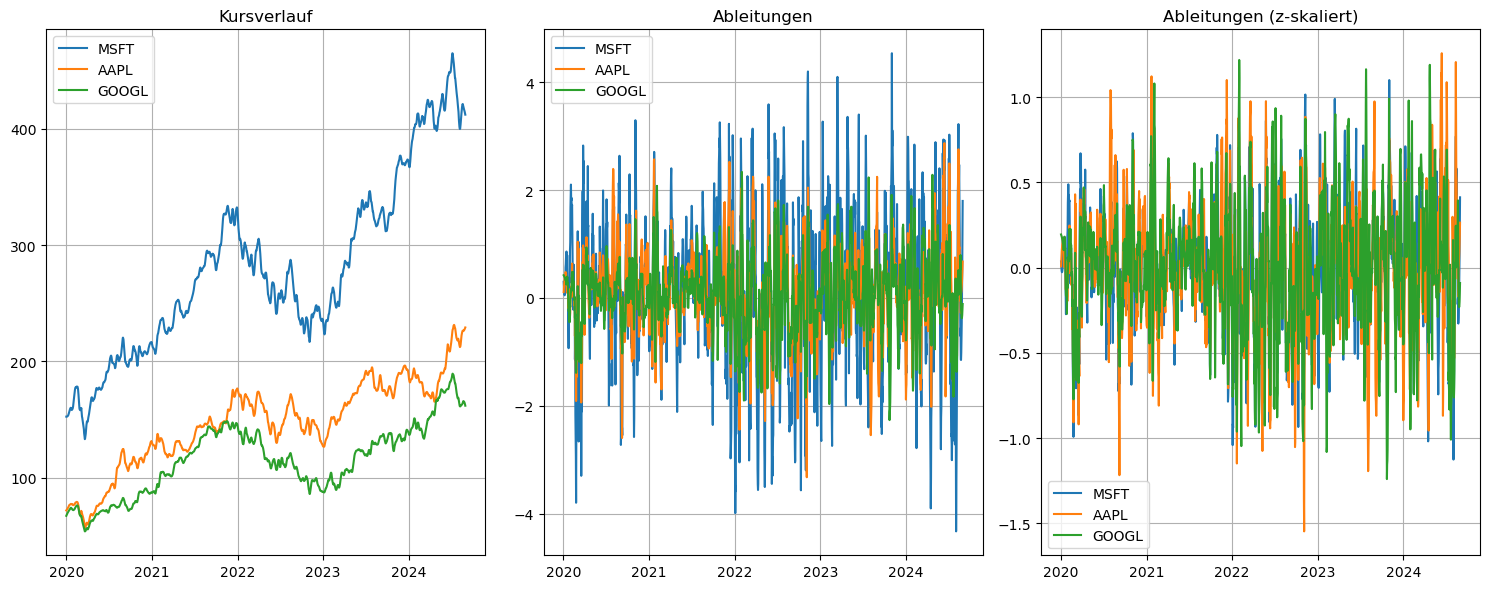

In [252]:
## Übersichtsgrafiken erzeugen

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Kurse
plt.subplot(1, 3, 1)
plt.title("Kursverlauf")
plt.grid(True)
for i in range(len(names)):
    plt.plot(dates, smoothedPrices[i], label=names[i])
plt.legend()

# Ableitungen
plt.subplot(1, 3, 2)
plt.title("Ableitungen")
plt.grid(True)
for i in range(len(names)):
    plt.plot(dates[1:], smoothedDerivatives[i], label=names[i])
plt.legend()

# Ableitungen (z-skaliert)
plt.subplot(1, 3, 3)
plt.title("Ableitungen (z-skaliert)")
plt.grid(True)
for i in range(len(names)):
    plt.plot(dates[1:], smoothedScaledDerivatives[i], label=names[i])
plt.legend()

plt.tight_layout()
plt.show()



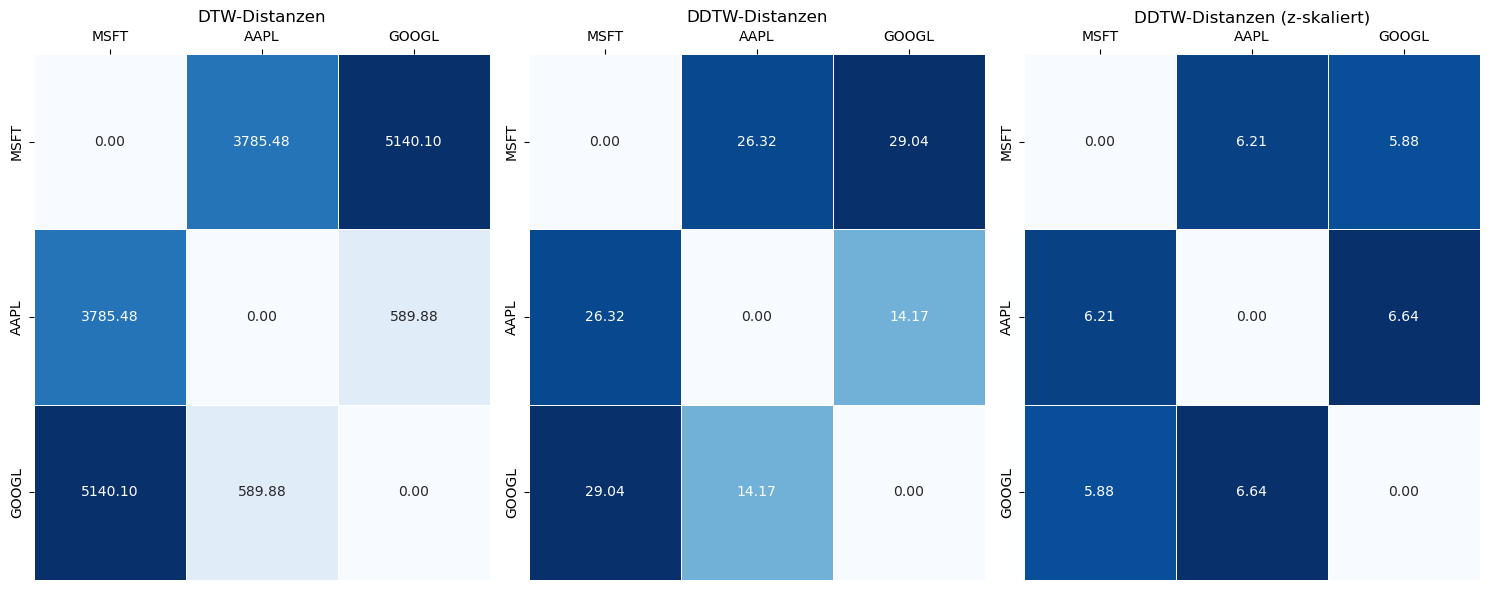

In [253]:
## DTW und DDTW analysieren

import itertools
from tslearn.metrics import dtw
import pandas as pd
import seaborn as sns

combinations = list(itertools.combinations(range(len(names)),2))

dtwMatrix = np.zeros((len(names),len(names)))
ddtwMatrix = np.zeros((len(names),len(names)))
ddtwsMatrix = np.zeros((len(names),len(names)))


for combination in combinations:
    i, j = combination
    dtwMatrix[i,j] = dtw(smoothedPrices[i],smoothedPrices[j])
    dtwMatrix[j,i] = dtwMatrix[i,j] # Symmetrie
    ddtwMatrix[i,j] = dtw(smoothedDerivatives[i],smoothedDerivatives[j])
    ddtwMatrix[j,i] = ddtwMatrix[i,j] # Symmetrie
    ddtwsMatrix[i,j] = dtw(smoothedScaledDerivatives[i],smoothedScaledDerivatives[j])
    ddtwsMatrix[j,i] = ddtwsMatrix[i,j] # Symmetrie

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.title("DTW-Distanzen")
hm = sns.heatmap(dtwMatrix, annot=True, fmt=".2f", cmap='Blues', linewidths=0.5, xticklabels=names, yticklabels=names, cbar=False)
hm.xaxis.set_ticks_position('top')
hm.xaxis.set_label_position('top')

plt.subplot(1, 3, 2)
plt.title("DDTW-Distanzen")
hm=sns.heatmap(ddtwMatrix, annot=True, fmt=".2f", cmap='Blues', linewidths=0.5, xticklabels=names, yticklabels=names, cbar=False)
hm.xaxis.set_ticks_position('top')
hm.xaxis.set_label_position('top')

plt.subplot(1, 3, 3)
plt.title("DDTW-Distanzen (z-skaliert)")
hm=sns.heatmap(ddtwsMatrix, annot=True, fmt=".2f", cmap='Blues', linewidths=0.5, xticklabels=names, yticklabels=names, cbar=False)
hm.xaxis.set_ticks_position('top')
hm.xaxis.set_label_position('top')

plt.tight_layout()
plt.show()


DTW Distance: 2.4001369219537385


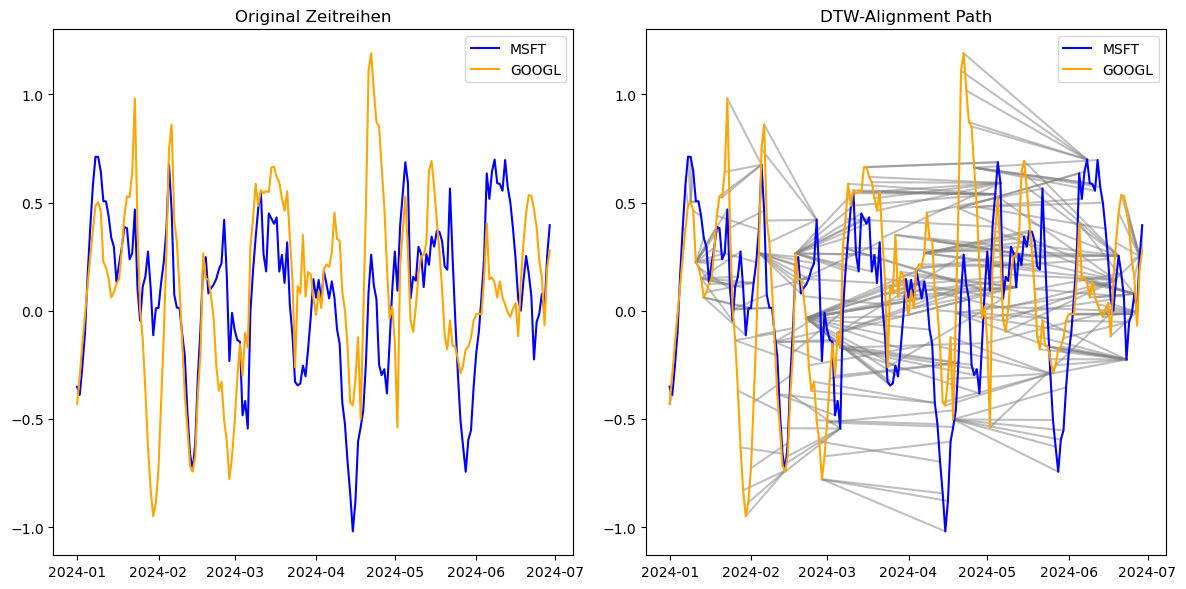

In [297]:
## DTW Pfad darstellen

from tslearn.metrics import dtw
from tslearn.metrics import dtw_path

TARGET = smoothedScaledDerivatives
ASSET_INDEX_1 = 0
ASSET_INDEX_2 = 2

ANALYZE_WINDOW = True
START = '2024-01-01'
END = '2024-06-30'

if ANALYZE_WINDOW:
    startIndex = None
    endIndex = None
    for i in range(len(dates)):
        if START == str(dates[i]): startIndex=i
        if END == str(dates[i]): endIndex=i

    if not startIndex: raise ValueError(f"START timestamp '{START}' not found!")
    if not endIndex: raise ValueError(f"END timestamp '{END}' not found!")
else:
    startIndex = 0
    endIndex = len(dates)-1

CMP1 = TARGET[ASSET_INDEX_1][startIndex:endIndex]
CMP2 = TARGET[ASSET_INDEX_2][startIndex:endIndex]

dtw_distance = dtw(CMP1, CMP2)
path, cost = dtw_path(CMP1, CMP2)

print(f'DTW Distance: {dtw_distance}')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(dates[startIndex:endIndex],CMP1, label=names[ASSET_INDEX_1], color='blue')
plt.plot(dates[startIndex:endIndex],CMP2, label=names[ASSET_INDEX_2], color='orange')
plt.title('Original Zeitreihen')
plt.legend()

plt.subplot(1, 2, 2)
for (i, j) in path:
    plt.plot([dates[startIndex:endIndex][i], dates[startIndex:endIndex][j]], [CMP1[i], CMP2[j]], color='gray', alpha=0.5)
plt.plot(dates[startIndex:endIndex],CMP1, label=names[ASSET_INDEX_1], color='blue')
plt.plot(dates[startIndex:endIndex],CMP2, label=names[ASSET_INDEX_2], color='orange')
plt.title('DTW-Alignment Path')
plt.legend()

plt.tight_layout()
plt.show()

Subsequence Analyse für GOOGL in Referenzfenster 2024-04-01 bis 2024-06-30:
Basierend auf Parametrisierung wurden 2 ähnliche Subsequences identifiziert



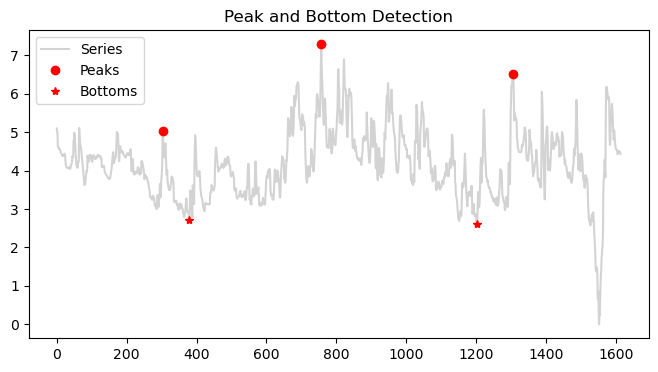

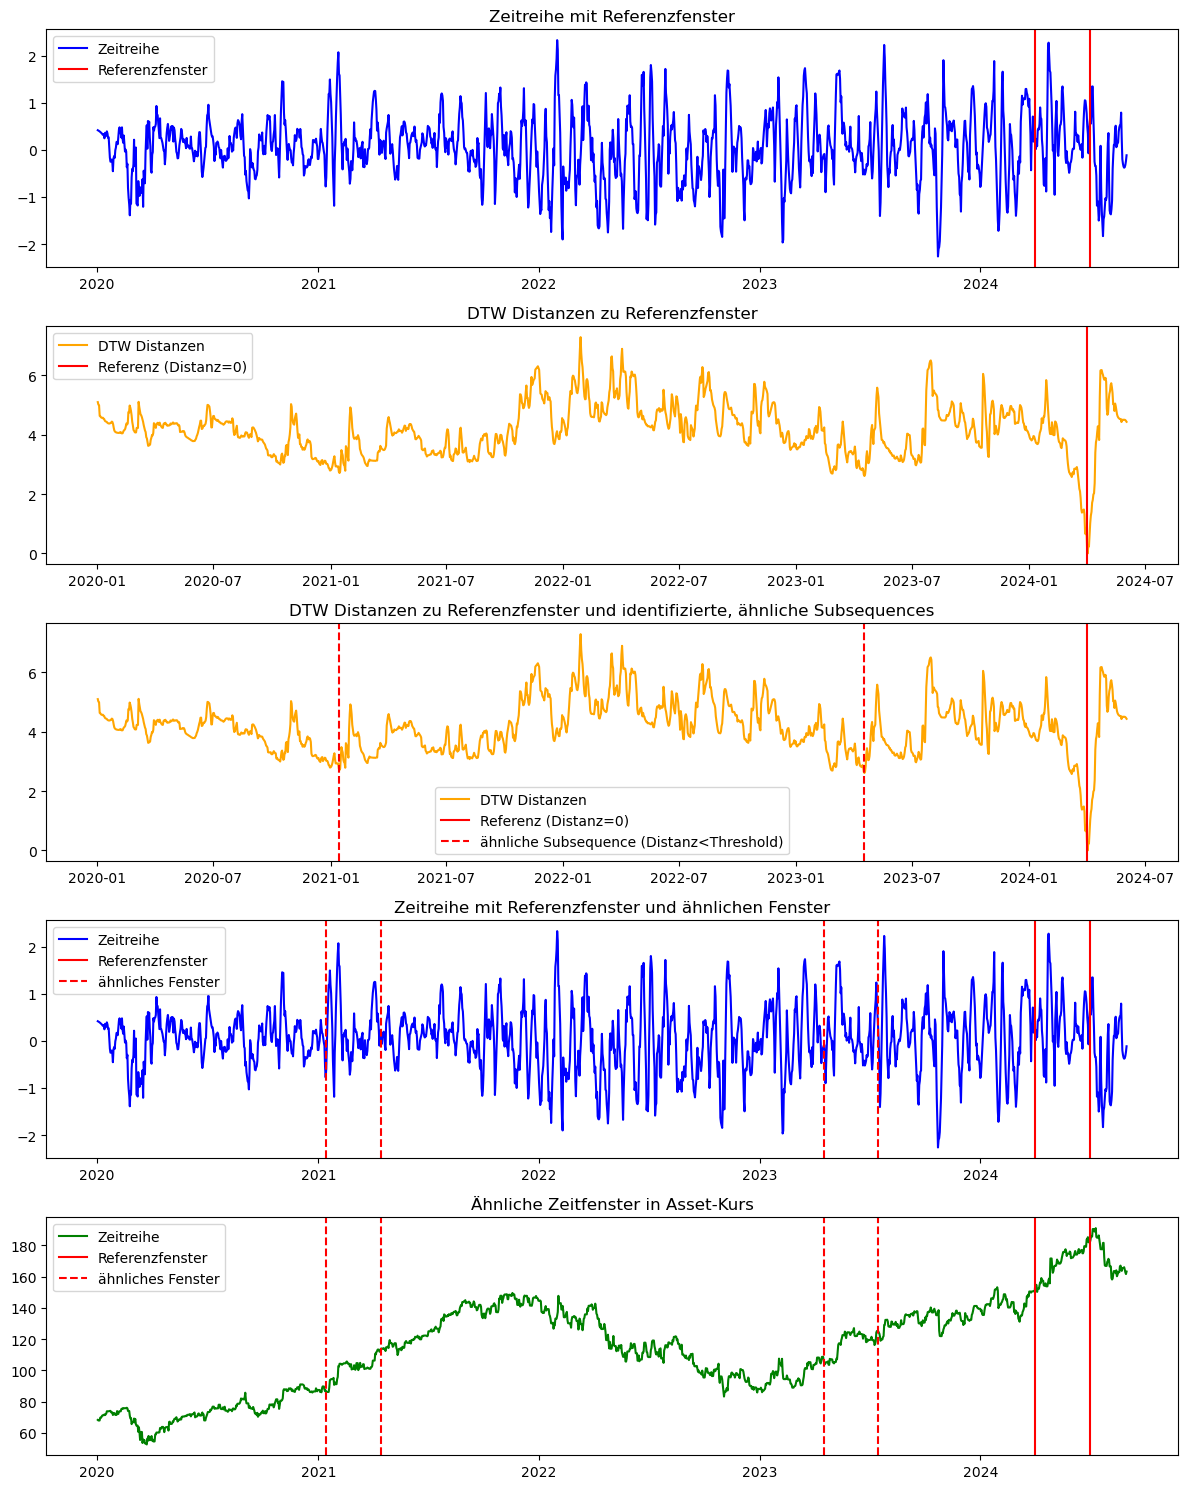

In [289]:
#SS(D)DTW
import numpy as np
import matplotlib.pyplot as plt
from tslearn.metrics import dtw

TARGET = smoothedDerivatives
ASSET_INDEX = 2
REFERENCE_END_DATE = '2024-06-30'
MATCHING_THRESHOLD = 3

SUBSEQUENCE_WINDOW_SIZE = 90
RW_WINDOW_SIZE = SUBSEQUENCE_WINDOW_SIZE * 2
ZSCALE_SUBSEQUENCES = False

print(f"Subsequence Analyse für {names[ASSET_INDEX]} in Referenzfenster {dates[startIndex]} bis {dates[endIndex]}:")

endIndex = None
for i in range(len(dates)):
    if REFERENCE_END_DATE == str(dates[i]): endIndex=i
if not endIndex: raise ValueError(f"REFERENCE_END_DATE timestamp '{REFERENCE_END_DATE}' not found!")
startIndex=endIndex-SUBSEQUENCE_WINDOW_SIZE
if startIndex < 0: raise ValueError(f"Start timestamp based on REFERENCE_END_DATE timestamp and WINDOW_SIZE is out of available data!")

# Referenzserie extrahieren
referenceTimeSeries = TARGET[ASSET_INDEX][startIndex:endIndex]
if ZSCALE_SUBSEQUENCES: referenceTimeSeries = z_scale(referenceTimeSeries)

# Subsequenceserien extrahieren und dtw Distanzen berechenn
subsequenceDistances = []
for i in range(len(TARGET[ASSET_INDEX]) - SUBSEQUENCE_WINDOW_SIZE + 1):
    currentSubsequence = TARGET[ASSET_INDEX][i:i + SUBSEQUENCE_WINDOW_SIZE]
    if ZSCALE_SUBSEQUENCES: currentSubsequence = z_scale(currentSubsequence)
    subsequenceDistances.append(dtw(currentSubsequence, referenceTimeSeries))

# lokale Minima mit RW-Algorithmus finden
peaks, bottoms = rw(subsequenceDistances,RW_WINDOW_SIZE,True)

# remove reference window if identified bottom
bottoms = [x for x in bottoms if x[1]!=startIndex]

# remove bottoms above MATCHING_THRESHOLD
bottoms = [x for x in bottoms if x[0]<MATCHING_THRESHOLD]

print(f"Basierend auf Parametrisierung wurden {len(bottoms)} ähnliche Subsequences identifiziert\n")

pricesOffest = 0 if np.array_equal(TARGET,prices) else 1

plt.figure(figsize=(12, (4+pricesOffest)*3))

plt.subplot(4+pricesOffest, 1, 1)
plt.plot(dates[0+pricesOffest:],TARGET[ASSET_INDEX], label='Zeitreihe', color='blue')
plt.axvline(dates[startIndex], color='red', linestyle='-', label='Referenzfenster')
plt.axvline(dates[endIndex], color='red', linestyle='-')
plt.title('Zeitreihe mit Referenzfenster')
plt.legend()

plt.subplot(4+pricesOffest, 1, 2)
plt.plot(dates[0+pricesOffest:len(dates)+pricesOffest-SUBSEQUENCE_WINDOW_SIZE],subsequenceDistances, label='DTW Distanzen', color='orange')
plt.title('DTW Distanzen zu Referenzfenster')
plt.axvline(dates[startIndex], color='red', linestyle='-', label='Referenz (Distanz=0)')
plt.legend()

plt.subplot(4+pricesOffest, 1, 3)
plt.plot(dates[0+pricesOffest:len(dates)+pricesOffest-SUBSEQUENCE_WINDOW_SIZE],subsequenceDistances, label='DTW Distanzen', color='orange')
plt.title('DTW Distanzen zu Referenzfenster und identifizierte, ähnliche Subsequences')
plt.axvline(dates[startIndex], color='red', linestyle='-', label='Referenz (Distanz=0)')
for i in range(len(bottoms)):
    plt.axvline(dates[int(bottoms[i][1])], color='red', linestyle='--', label='ähnliche Subsequence (Distanz<Threshold)' if i==0 else None)
plt.legend()

plt.subplot(4+pricesOffest, 1, 4)
plt.plot(dates[0+pricesOffest:],TARGET[ASSET_INDEX], label='Zeitreihe', color='blue')
plt.title('Zeitreihe mit Referenzfenster und ähnlichen Fenster')
plt.axvline(dates[startIndex], color='red', linestyle='-', label='Referenzfenster')
plt.axvline(dates[endIndex], color='red', linestyle='-')
for i in range(len(bottoms)):
    plt.axvline(dates[int(bottoms[i][1])], color='red', linestyle='--', label='ähnliches Fenster' if i==0 else None)
    plt.axvline(dates[int(bottoms[i][1])]+SUBSEQUENCE_WINDOW_SIZE, color='red', linestyle='--')
plt.legend()

if 4+pricesOffest==5:
    plt.subplot(4+pricesOffest, 1, 5)
    plt.plot(dates[1:],prices[ASSET_INDEX][1:], label='Zeitreihe', color='green')
    plt.title('Ähnliche Zeitfenster in Asset-Kurs')
    plt.axvline(dates[startIndex], color='red', linestyle='-', label='Referenzfenster')
    plt.axvline(dates[endIndex], color='red', linestyle='-')
    for i in range(len(bottoms)):
        plt.axvline(dates[int(bottoms[i][1])], color='red', linestyle='--', label='ähnliches Fenster' if i==0 else None)
        plt.axvline(dates[int(bottoms[i][1])]+SUBSEQUENCE_WINDOW_SIZE, color='red', linestyle='--')
    plt.legend()


plt.tight_layout()
plt.show()
